<a href="https://colab.research.google.com/github/AK-T2024/AK-T2024/blob/main/vegClassifier_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Classification using a CNN**

The aim of this project is to build a multiclass classifier for the purpose of identifying images of vegetables.

**The Data**

Dataset ref: https://www.researchgate.net/publication/352846889_DCNN-Based_Vegetable_Image_Classification_Using_Transfer_Learning_A_Comparative_Study

The data consists of 21,000 images of vegetables. Each image contains only one type of vegetable and there are 15 different classes of vegetables. A split of approximately 70-15-15 is applied to the data to form training, validation and testing subsets.

In [106]:
# load required packages:

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics

import matplotlib.pyplot as plt
import tensorflow as tf
import random
import pandas as pd
import numpy as np
import os


In [3]:
# Set seed for reproducibility
tf.random.set_seed(20240126)

In [4]:
# Mount drive to access locally stored data:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
# specify the path to the data:
folder_path = '/content/drive/MyDrive/ImageClassification'

# change to the specified folder
os.chdir(folder_path)

In [87]:
# Define path to data:

train_dir = 'Vegetable Images/train'
validation_dir = 'Vegetable Images/validation'
test_dir = 'Vegetable Images/test'

# Identify the class names
classes = os.listdir(train_dir)

# Set parameters:
targetSize = (224,224)
batchSize = 25

# Create data generators
train_data_gen = ImageDataGenerator(rescale=1./255)
validation_data_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1./255)

train_generator = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    image_size = targetSize,
    batch_size = batchSize,
)

validation_generator = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    label_mode='categorical',
    image_size= targetSize,
    batch_size= batchSize,
)

test_generator = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size= targetSize,
    batch_size= batchSize,
)


Found 15000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


**Exploring the data**



In [63]:
# Create a dictionary of all images:

def list_all_paths(directory):
  all_paths = []
  for root, dirs, files in os.walk(directory):
    for file in files:
        file_path = os.path.join(root, file)
        all_paths.append(file_path)
  return all_paths

# Set up dict for image counts within class
cl_count = {}
# Set up dict for image counts within class
image_ref = {}

for cl in classes:
  class_path = 'Vegetable Images/train/{}'.format(cl)
  all_paths_in_class = list_all_paths(class_path)
  # count number of images in each class and store
  cl_count[cl] = len(all_paths_in_class)
  # select random item from list of image paths
  image_path = random.choice(all_paths_in_class)
  # load image using keras utility function and save it in image_dict
  image_ref[cl] = tf.keras.utils.load_img(image_path)


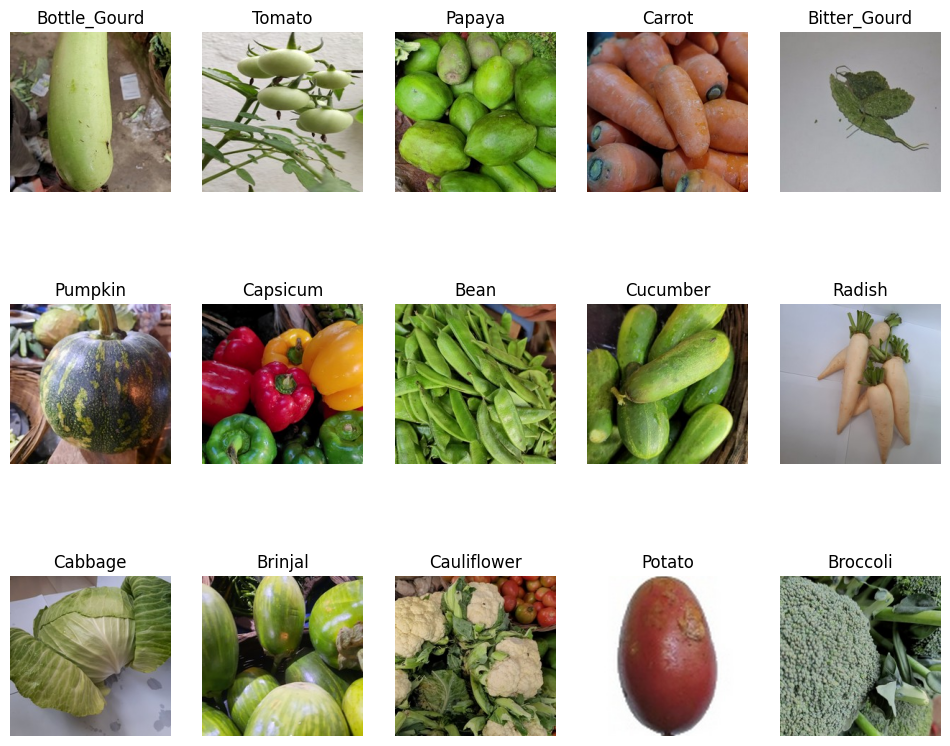

In [62]:
# Show the randomly selected images from each class:

plt.figure(figsize=(12, 10))
# iterate over classes and randomly selected images
for i, (cl,img) in enumerate(image_ref.items()):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(img)
    plt.title(f'{cl}')
    plt.axis('off')

In [67]:
# Table to show count within each class:
# check for imbalance between classes

# Create a DataFrame from the dictionary
df = pd.DataFrame(list(cl_count.items()), columns=['Class', 'Image Count'])

# Print the DataFrame
print(df)

           Class  Image Count
0   Bottle_Gourd         1000
1         Tomato         1000
2         Papaya         1000
3         Carrot         1000
4   Bitter_Gourd         1000
5        Pumpkin         1000
6       Capsicum         1000
7           Bean         1000
8       Cucumber         1000
9         Radish         1000
10       Cabbage         1000
11       Brinjal         1000
12   Cauliflower         1000
13        Potato         1000
14      Broccoli         1000


**CNN model**

In [122]:
# Function to produce learning curves:

def learning_curves(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(10, 5))
  for ind, metric in enumerate(metrics):
    ax[ind].plot(history.history[metric])
    ax[ind].plot(history.history['val_' + metric], ls='dotted');
    ax[ind].set_xlabel("No. of Epochs")
    ax[ind].set_ylabel(metric)
    ax[ind].legend([metric, 'val_' + metric])

# Function to calculate the test accuracy:

def test_accuracy(model):
    test_acc =model.evaluate(test_generator)
    test_acc_perc = test_acc[1] * 100
    print(f'Test Accuracy: {test_acc_perc:.2f}%')

In [84]:
# Define CNN model 1:

model1 = keras.Sequential(
    name = "model1",
    layers=[
      layers.Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)),
      layers.BatchNormalization(),
      layers.MaxPooling2D(),
      layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
      layers.BatchNormalization(),
      layers.MaxPooling2D(),
      layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
      layers.BatchNormalization(),
      layers.MaxPooling2D(),
      layers.GlobalAveragePooling2D(),
      layers.Dense(128,activation='relu'),
      layers.Dense(15, activation='softmax')
  ]
)

In [85]:
model1.summary()

Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 batch_normalization_3 (Batc  (None, 222, 222, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 109, 109, 32)      18464     
                                                                 
 batch_normalization_4 (Batc  (None, 109, 109, 32)     128       
 hNormalization)                                                 
                                                            

In [86]:
# Compile CNN model 1:

model1.compile(
    loss='categorical_crossentropy',
    optimizer= 'adam',
    metrics=['accuracy']
)

In [93]:
# Fit CNN model 1:

fit_m1 = model1.fit(
    train_generator,
    steps_per_epoch=24,
    epochs=25,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=10)]
)

Epoch 1/25
24/24 [==============================] - 161s 7s/step - loss: 0.5199 - accuracy: 0.8400 - val_loss: 1.5419 - val_accuracy: 0.4928
Epoch 2/25
24/24 [==============================] - 157s 7s/step - loss: 0.4476 - accuracy: 0.8533 - val_loss: 1.6607 - val_accuracy: 0.5168
Epoch 3/25
24/24 [==============================] - 156s 7s/step - loss: 0.4462 - accuracy: 0.8583 - val_loss: 2.8730 - val_accuracy: 0.3648
Epoch 4/25
24/24 [==============================] - 172s 7s/step - loss: 0.4425 - accuracy: 0.8683 - val_loss: 1.1254 - val_accuracy: 0.6848
Epoch 5/25
24/24 [==============================] - 156s 7s/step - loss: 0.4008 - accuracy: 0.8867 - val_loss: 0.7456 - val_accuracy: 0.7456
Epoch 6/25
24/24 [==============================] - 156s 7s/step - loss: 0.3398 - accuracy: 0.8883 - val_loss: 0.5621 - val_accuracy: 0.8064
Epoch 7/25
24/24 [==============================] - 156s 7s/step - loss: 0.3666 - accuracy: 0.8917 - val_loss: 0.8366 - val_accuracy: 0.7280
Epoch 8/25
24

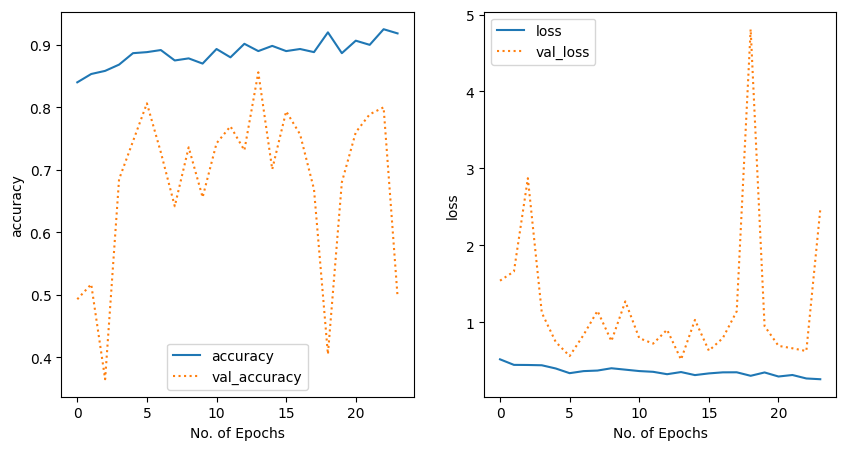

In [94]:
# Plot the learning curves:

learning_curves(['accuracy', 'loss'], fit_m1)

In [123]:
# Calculate the model accuracy on the test data:

test_accuracy(model1)

120/120 [==============================] - 156s 1s/step - loss: 2.4015 - accuracy: 0.5067
Test Accuracy: 50.67%
